In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

#Import standard pydata libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
filename = 'facies_PE_ET_dum.csv'
training_data = pd.read_csv(filename)
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')                            
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,C LM,A1 LM,A1 SH,C SH,B5 LM,B1 SH,B3 SH,B4 SH,B2 SH,B1 LM,B2 LM,B5 SH,B4 LM,B3 LM
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.761512,1.518438,0.521852,0.159557,0.142444,0.101711,0.094481,0.087250,0.080742,0.065076,0.062425,0.051097,0.050615,0.042420,0.023138,0.021210,0.017836
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.839810,0.499720,0.286644,0.366238,0.349547,0.302305,0.292531,0.282235,0.272472,0.246690,0.241954,0.220221,0.219236,0.201569,0.150360,0.144101,0.132370
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.600000,2.000000,0.528000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dfs = []
for well in training_data['Well Name'].unique():
    df = training_data[training_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR']:
        smooth_col = 'smooth_'+col
        df[smooth_col] = df[col].rolling(25).mean()
        df[smooth_col].fillna(method='ffill', inplace=True)
        df[smooth_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
training_data = pd.concat(dfs)
formation_encoder = dict(zip(training_data.Formation.unique(), range(len(training_data.Formation.unique()))))
training_data['enc_formation'] = training_data.Formation.map(formation_encoder)

In [ ]:
training_data.to_csv('validation_data_nofacies_dum.csv')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,C LM,A1 LM,A1 SH,C SH,B5 LM,B1 SH,B3 SH,B4 SH,B2 SH,B1 LM,B2 LM,B5 SH,B4 LM,B3 LM
0,3,3,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3,3,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,3,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,3,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3,3,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,1,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4145,5,1,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4146,5,1,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4147,5,1,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Let's build a model
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from classification_utilities import display_cm
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import train_test_split



In [ ]:
#We will take a look at an F1 score for each well
n_estimators=100
learning_rate=.01
random_state=0
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
title_length = 20 
wells = training_data['Well Name'].unique()

In [ ]:
for well in wells:
    blind = training_data[training_data['Well Name']==well]
    train = training_data[(training_data['Well Name']!=well)]
    
    train_X = train.drop(['Formation', 'Well Name', 'Depth', 'Facies'], axis=1)
    train_Y = train.Facies.values
    test_X = blind.drop(['Formation', 'Well Name', 'Facies', 'Depth'], axis=1)
    test_Y = blind.Facies.values
    clf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=learning_rate, random_state=random_state, algorithm='SAMME.R')
    clf.fit(X=train_X, y=train_Y)
    pred_Y = clf.predict(test_X)
    f1 = metrics.f1_score(test_Y, pred_Y, average='micro')
    print("*"*title_length)
    print("{well}={f1:.4f}".format(well=well,f1=f1))
    print("*"*title_length)

********************
SHRIMPLIN=0.6030
********************
********************
ALEXANDER D=0.6330
********************
********************
SHANKLE=0.4833
********************
********************
LUKE G U=0.5835
********************
********************
KIMZEY A=0.5421
********************
********************
CROSS H CATTLE=0.4172
********************
********************
NOLAN=0.5205
********************
********************
Recruit F9=0.9000
********************
********************
NEWBY=0.4622
********************
********************
CHURCHMAN BIBLE=0.5792
********************


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(training_data.drop(['Formation', 'Well Name','Facies', 'Depth'], axis=1), training_data.Facies.values, test_size=.2)

In [ ]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(3319, 21)
(3319,)
(830, 21)
(830,)


In [ ]:
clf = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=learning_rate, random_state=0, algorithm='SAMME.R')
clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
cm = metrics.confusion_matrix(y_true=test_Y, y_pred=pred_Y)
display_cm(cm, facies_labels, display_metrics=True)

     Pred
            SS
          CSiS
          FSiS
          SiSh
            MS
            WS
             D
            PS
            BS
         Total
     True
            SS
            40
            13
             5
              
              
              
              
              
              
            58
          CSiS
             1
           153
            26
              
              
              
              
             2
              
           182
          FSiS
             1
            37
           135
              
              
              
              
              
              
           173
          SiSh
              
              
             1
            44
             3
             3
              
             2
              
            53
            MS
              
             2
              
             4
            26
            12
             1
             7
              
            52
     

In [ ]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy(cm):
    total_correct = 0.
    nb_classes = cm.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += cm[i][i]
    acc = total_correct/sum(sum(cm))
    return acc

def accuracy_adjacent(cm, adjacent_facies):
    nb_classes = cm.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += cm[i][i]
        for j in adjacent_facies[i]:
            total_correct += cm[i][j]
    return total_correct / sum(sum(cm))

In [ ]:
print ('Facies classification accuracy = %f' % accuracy(cm))
print ('Adjacent facies classification accuracy = %f' % accuracy_adjacent(cm, adjacent_facies)) 

Facies classification accuracy = 0.777108
Adjacent facies classification accuracy = 0.955422


Text(0.5, 1.0, 'Confusion Matrix')

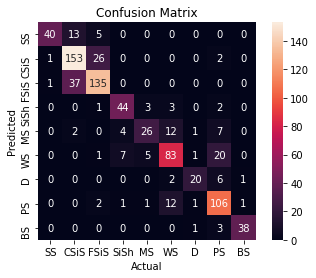

In [ ]:
axes = sns.heatmap(cm,annot=True, fmt="d",square=True, cbar=True, xticklabels= facies_labels, yticklabels= facies_labels)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.set_title('Confusion Matrix')